In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# SBSim: A tutorial of using Reinforcement Learning for Optimizing Energy Use and Minimizing Carbon Emission in Office Buildings

___

Commercial office buildings contribute 17 percent of Carbon Emissions in the US, according to the US Energy Information Administration (EIA), and improving their efficiency will reduce their environmental burden and operating cost. A major contributor of energy consumption in these buildings are the Heating, Ventilation, and Air Conditioning (HVAC) devices. HVAC devices form a complex and interconnected thermodynamic system with the building and outside weather conditions, and current setpoint control policies are not fully optimized for minimizing energy use and carbon emission. Given a suitable training environment, a Reinforcement Learning (RL) agent is able to improve upon these policies, but training such a model, especially in a way that scales to thousands of buildings, presents many practical challenges. Most existing work on applying RL to this important task either makes use of proprietary data, or focuses on expensive and proprietary simulations that may not be grounded in the real world. We present the Smart Buildings Control Suite, the first open source interactive HVAC control dataset extracted from live sensor measurements of devices in real office buildings. The dataset consists of two components: real-world historical data from two buildings, for offline RL, and a lightweight interactive simulator for each of these buildings, calibrated using the historical data, for online and model-based RL. For ease of use, our RL environments are all compatible with the OpenAI gym environment standard. We believe this benchmark will accelerate progress and collaboration on HVAC optimization.

---

This notebook accompanies the paper titled, **Real-World Data and Calibrated Simulation Suite for Offline Training of Reinforcement Learning Agents to Optimize Energy and Emission in Office Buildings** by Judah Goldfeder and John Sipple.

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
# @title Imports
from dataclasses import dataclass
import datetime, pytz
import enum
import functools
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import time
from typing import Final, Sequence
from typing import Optional
from typing import Union, cast
os.environ['WRAPT_DISABLE_EXTENSIONS'] = 'true'
from absl import logging
import gin
from matplotlib import patches
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd
import reverb
import mediapy as media
from IPython.display import clear_output
import sys

2024-12-10 07:42:55.055362: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 07:42:57.225394: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-10 07:43:01.972554: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 07:43:01.975398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 07:43:02.358440: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [4]:
sys.path.append("/burg/home/ssa2206/sbsim_dual_control/smart_control/notebooks/")

In [5]:
from smart_control.environment import environment

from smart_control.proto import smart_control_building_pb2, smart_control_normalization_pb2
from smart_control.reward import electricity_energy_cost, natural_gas_energy_cost, setpoint_energy_carbon_reward, setpoint_energy_carbon_regret

from smart_control.simulator import randomized_arrival_departure_occupancy, rejection_simulator_building
from smart_control.simulator import simulator_building, step_function_occupancy, stochastic_convection_simulator

from smart_control.utils import bounded_action_normalizer, building_renderer, controller_reader
from smart_control.utils import controller_writer, conversion_utils, observation_normalizer, reader_lib
from smart_control.utils import writer_lib, histogram_reducer, environment_utils

In [6]:
import tensorflow as tf
from tf_agents.agents.sac import sac_agent, tanh_normal_projection_network
from tf_agents.drivers import py_driver
from tf_agents.keras_layers import inner_reshape
from tf_agents.metrics import py_metrics
from tf_agents.networks import nest_map, sequential
from tf_agents.policies import greedy_policy, py_tf_eager_policy, random_py_policy, tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer, reverb_utils
from tf_agents.specs import tensor_spec
from tf_agents.train import actor, learner, triggers
from tf_agents.train.utils import spec_utils, train_utils
from tf_agents.trajectories import policy_step
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import trajectory as trajectory_lib
from tf_agents.trajectories import trajectory
from tf_agents.typing import types

In [7]:
from env_loader import load_envs
from plot_utils import *


In [8]:
# @title Set local runtime configurations


def logging_info(*args):
    logging.info(*args)
    print(*args)

data_path = "/burg/home/ssa2206/sbsim_dual_control/smart_control/configs/resources/sb1/" #@param {type:"string"}
metrics_path = "/burg/home/ssa2206/sbsim_dual_control/metrics" #@param {type:"string"}
output_data_path = '/burg/home/ssa2206/sbsim_dual_control/output' #@param {type:"string"}
root_dir = "/burg/home/ssa2206/sbsim_dual_control/root" #@param {type:"string"}

!mkdir -p $root_dir
!mkdir -p $output_data_path
!mkdir -p $metrics_path




def remap_filepath(filepath) -> str:
    return str(filepath)


In [9]:
# @title Plotting Utities
reward_shift = 0
reward_scale = 1.0
person_productivity_hour = 300.0
time_zone = "US/Pacific"

KELVIN_TO_CELSIUS = 273.15

def render_env(env: environment.Environment):
    """Renders the environment."""
    building_layout = env.building._simulator._building._floor_plan

    # create a renderer
    renderer = building_renderer.BuildingRenderer(building_layout, 1)

    # get the current temps to render
    # this also is not ideal, since the temps are not fully exposed.
    # V Ideally this should be a publicly accessable field
    temps = env.building._simulator._building.temp

    input_q = env.building._simulator._building.input_q

    # render
    vmin = 285
    vmax = 305
    image = renderer.render(temps, cmap='bwr', vmin=vmin, vmax=vmax, colorbar=False, 
                            input_q=input_q, diff_range=0.5, diff_size=1,).convert('RGB')
    media.show_image(image, title='Environment %s' % env.current_simulation_timestamp)

In [10]:
eval_env, collect_env, initial_collect_env = load_envs(data_path, metrics_path)

/burg/home/ssa2206/sbsim_dual_control/smart_control/configs/resources/sb1/sim_config.gin
/burg/home/ssa2206/sbsim_dual_control/smart_control/configs/resources/sb1/sim_config.gin


In [11]:
eval_env._building_image_generator

In [12]:
eval_env._metrics_path

'/burg/home/ssa2206/sbsim_dual_control/metrics'

In the section below, we'll define a function that accepts the envirnment and a policy, and runs a fixed number of episodes. The policy can be a rules-based policy or an RL-based policy.

In [13]:
# @title Define a method to execute the policy on the environment.


def get_trajectory(time_step, current_action: policy_step.PolicyStep):
    """Get the trajectory for the current action and time step."""
    observation = time_step.observation
    action = current_action.action
    policy_info = ()
    reward = time_step.reward
    discount = time_step.discount

    if time_step.is_first():
        return(trajectory.first(observation, action, policy_info, reward, discount))
    elif time_step.is_last():
        return(trajectory.last(observation, action, policy_info, reward, discount))
    else:
        return(trajectory.mid(observation, action, policy_info, reward, discount))


def compute_avg_return(environment, policy, num_episodes=1, time_zone: str = "US/Pacific", 
                       render_interval_steps: int = 24,trajectory_observers=None,):
    """Computes the average return of the policy on the environment.
    Args:
    environment: environment.Environment
    policy: policy.Policy
    num_episodes: total number of eposides to run.
    time_zone: time zone of the environment
    render_interval_steps: Number of steps to take between rendering.
    trajectory_observers: list of trajectory observers for use in rendering.
    """
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        t0 = time.time()
        epoch = t0
        step_id = 0
        execution_times = []
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)

            if trajectory_observers is not None:
                traj = get_trajectory(time_step, action_step)
                for observer in trajectory_observers:
                    observer(traj)

            episode_return += time_step.reward
            t1 = time.time()
            dt = t1 - t0
            episode_seconds = t1 - epoch
            execution_times.append(dt)
            sim_time = environment.current_simulation_timestamp.tz_convert(time_zone)

            print("Step %5d Sim Time: %s, Reward: %8.2f, Return: %8.2f, Mean Step Time:"
                  " %8.2f s, Episode Time: %8.2f s" % (step_id, sim_time.strftime("%Y-%m-%d %H:%M"),
                                                       time_step.reward, episode_return, 
                                                       np.mean(execution_times), episode_seconds,)
                 )
            if (step_id > 0) and (step_id % render_interval_steps == 0):
                if environment._metrics_path:
                    clear_output(wait=True)
                    reader = get_latest_episode_reader(environment._metrics_path)
                    plot_timeseries_charts(reader, time_zone)
                render_env(environment)

            t0 = t1
            step_id += 1
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return

Next, we will run the static control setpoints on the environment to establish baseline performance.

**Note:** This will take some time to execute. Feel free to skip this step if you want to jump directly to the RL section below.

In [14]:
# @title Optionally, execute the schedule policy on the environment
# Optional
#compute_avg_return(eval_env, schedule_policy, 1, time_zone="US/Pacific", render_interval_steps=144, trajectory_observers=None)

# Reinforcement Learning Control
In the previous section we used a simple schedule to control the HVAC setpoints, however in this section, we configure and train a Reinforcement Learning (RL) agent.



In [15]:

# @title Utilities to configure networks for the RL Agent.
dense = functools.partial(
    tf.keras.layers.Dense,
    activation=tf.keras.activations.relu,
    kernel_initializer='glorot_uniform',
)


def logging_info(*args):
    logging.info(*args)
    print(*args)


def create_fc_network(layer_units):
    return sequential.Sequential([dense(num_units) for num_units in layer_units])


def create_identity_layer():
    return tf.keras.layers.Lambda(lambda x: x)


### SAC Critic Network

- obs network learns meaningful representation of state 
- action network learns meaningful representation of action
- joint network $f(z_a, z_s) \rightarrow \hat{Q}(s, a)$

In [16]:
def create_sequential_critic_network(obs_fc_layer_units, action_fc_layer_units, joint_fc_layer_units):
    """Create a sequential critic network."""
    # Split the inputs into observations and actions.
    def split_inputs(inputs):
        return {'observation': inputs[0], 'action': inputs[1]}

    # Create an observation network.
    obs_network = (
        create_fc_network(obs_fc_layer_units) if obs_fc_layer_units else create_identity_layer()
    )

    # Create an action network.
    action_network = (
        create_fc_network(action_fc_layer_units) if action_fc_layer_units else create_identity_layer()
    )

    # Create a joint network.
    joint_network = (
        create_fc_network(joint_fc_layer_units) if joint_fc_layer_units else create_identity_layer()
    )

    # Final layer.
    value_layer = tf.keras.layers.Dense(1, kernel_initializer='glorot_uniform')

    return sequential.Sequential(
        [
            tf.keras.layers.Lambda(split_inputs),
            nest_map.NestMap({'observation': obs_network, 'action': action_network}),
            nest_map.NestFlatten(),
            tf.keras.layers.Concatenate(),
            joint_network,
            value_layer,
            inner_reshape.InnerReshape(current_shape=[1], new_shape=[]),
        ],
        name='sequential_critic',
    )



Instead of just an action, returns prob distribution over actions

In [17]:

class _TanhNormalProjectionNetworkWrapper(
        tanh_normal_projection_network.TanhNormalProjectionNetwork
):
    """Wrapper to pass predefined `outer_rank` to underlying projection net."""

    def __init__(self, sample_spec, predefined_outer_rank=1):
        super(_TanhNormalProjectionNetworkWrapper, self).__init__(sample_spec)
        self.predefined_outer_rank = predefined_outer_rank

    def call(self, inputs, network_state=(), **kwargs):
        kwargs['outer_rank'] = self.predefined_outer_rank
        if 'step_type' in kwargs:
            del kwargs['step_type']
        return super(_TanhNormalProjectionNetworkWrapper, self).call(inputs, **kwargs)


def create_sequential_actor_network(actor_fc_layers, action_tensor_spec):
    """Create a sequential actor network."""

    def tile_as_nest(non_nested_output):
        return tf.nest.map_structure(
                lambda _: non_nested_output, action_tensor_spec
        )

    return sequential.Sequential(
            [dense(num_units) for num_units in actor_fc_layers]
            + [tf.keras.layers.Lambda(tile_as_nest)]
            + [nest_map.NestMap(tf.nest.map_structure(_TanhNormalProjectionNetworkWrapper, 
                                                      action_tensor_spec))])

Set the configuration parameters for the SAC Agent

In [18]:
# @title Set the RL Agent's parameters

# Actor network fully connected layers.
actor_fc_layers = (128, 128)
# Critic network observation fully connected layers.
critic_obs_fc_layers = (128, 64)
# Critic network action fully connected layers.
critic_action_fc_layers = (128, 64)
# Critic network joint fully connected layers.
critic_joint_fc_layers = (128, 64)

batch_size = 256
actor_learning_rate = 3e-4
critic_learning_rate = 3e-4
alpha_learning_rate = 3e-4
gamma = 0.99
target_update_tau= 0.005
target_update_period= 1
reward_scale_factor = 1.0

# Replay params
replay_capacity = 1000000
debug_summaries = True
summarize_grads_and_vars = True


## Initialize the SAC agent

Of all the Reinforcement learning algorithms, we have chosen [Soft Actor Cirtic (SAC)](https://arxiv.org/abs/1801.01290) because its proven performance on evironments with  high-dimensional states and real-valued actions.

In this notebook we illustrate the use of the buidling control environment using the SAC implementation in [TF-Agents](https://www.tensorflow.org/agents).

In [19]:
# @title Construct the SAC agent

_, action_tensor_spec, time_step_tensor_spec = spec_utils.get_tensor_specs(
    collect_env
)

actor_net = create_sequential_actor_network(
    actor_fc_layers=actor_fc_layers, action_tensor_spec=action_tensor_spec
)

critic_net = create_sequential_critic_network(
    obs_fc_layer_units=critic_obs_fc_layers,
    action_fc_layer_units=critic_action_fc_layers,
    joint_fc_layer_units=critic_joint_fc_layers,
)


In [20]:
train_step = train_utils.create_train_step()
agent = sac_agent.SacAgent(
    time_step_tensor_spec,
    action_tensor_spec,
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.keras.optimizers.Adam(learning_rate=actor_learning_rate),
    critic_optimizer=tf.keras.optimizers.Adam(
        learning_rate=critic_learning_rate
    ),
    alpha_optimizer=tf.keras.optimizers.Adam(learning_rate=alpha_learning_rate),
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    td_errors_loss_fn=tf.math.squared_difference,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    gradient_clipping=None,
    debug_summaries=debug_summaries,
    summarize_grads_and_vars=summarize_grads_and_vars,
    train_step_counter=train_step,
)
agent.initialize()

Below we construct a replay buffer using reverb. The replay buffer is populated with state-action-reward-state tuples during collect. Thie allows the agent to relive past experiences, and prevents the model from overfitting in the local neighborhood.

During traning, the agent samples from the replay buffer. This helps decorrelate the training data in a way that randomization of a training set would in supervised learning. Otherwise, in most environments the experience in a window of time is highly correlated.

In [21]:
# @title Set up the replay buffer
replay_capacity = 50000
table_name = 'uniform_table'
table = reverb.Table(
    table_name,
    max_size=replay_capacity,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
)

reverb_checkpoint_dir = output_data_path + "/reverb_checkpoint"
reverb_port = None
print('reverb_checkpoint_dir=%s' %reverb_checkpoint_dir)
reverb_checkpointer = reverb.platform.checkpointers_lib.DefaultCheckpointer(path=reverb_checkpoint_dir)
reverb_server = reverb.Server([table], port=reverb_port, checkpointer=reverb_checkpointer)
logging_info('reverb_server_port=%d' % reverb_server.port)
reverb_replay = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    sequence_length=2,
    table_name=table_name,
    local_server=reverb_server,
)
rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
    reverb_replay.py_client, table_name, sequence_length=2, stride_length=1
)
print('num_frames in replay buffer=%d' %reverb_replay.num_frames())

reverb_checkpoint_dir=/burg/home/ssa2206/sbsim_dual_control/output/reverb_checkpoint
reverb_server_port=37451
num_frames in replay buffer=574


[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /burg/home/ssa2206/sbsim_dual_control/output/reverb_checkpoint.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /burg/home/ssa2206/sbsim_dual_control/output/reverb_checkpoint
[reverb/cc/platform/tfrecord_checkpointer.cc:286] Loading checkpoint from /burg/home/ssa2206/sbsim_dual_control/output/reverb_checkpoint/2024-12-05T20:44:35.347939741-05:00
[reverb/cc/platform/tfrecord_checkpointer.cc:295] Loading and verifying metadata of the checkpointed tables.
[reverb/cc/platform/tfrecord_checkpointer.cc:341] Metadata for table 'uniform_table' was successfully loaded and verified.
[reverb/cc/platform/tfrecord_checkpointer.cc:404] Successfully loaded and verified metadata for all (1) tables. We'll now proceed to read the data referenced by the items in the table.
[reverb/cc/platform/tfrecord_checkpointer.cc:447] Still reading compressed trajectory data. 1 records have been re

For simplicity, we'll grab eval and collact policies and give them short variable names.

In [22]:
# @title Access the eval and collect policies
eval_policy = agent.policy
collect_policy = agent.collect_policy

In the next section we define observer classes that enable printing model and environment output as the scenario evolves to who you the percentage of the episode, the timestamp in the scenario, cumulative reward, and the execution time.

We also provide a plot observer that periodically outputs the performance charts and the temperature gradient across both floors of the buidling.

In [23]:
eval_env._metrics_path

'/burg/home/ssa2206/sbsim_dual_control/metrics'

In [24]:
# @title Define Observers
class RenderAndPlotObserver:
    """Renders and plots the environment."""
    def __init__(self, render_interval_steps: int = 10, environment=None,):
        self._counter = 0
        self._render_interval_steps = render_interval_steps
        self._environment = environment
        self._cumulative_reward = 0.0
        self._start_time = None
        if self._environment is not None:
            self._num_timesteps_in_episode = (self._environment._num_timesteps_in_episode)
            self._environment._end_timestamp

    def __call__(self, trajectory: trajectory_lib.Trajectory) -> None:
        reward = trajectory.reward
        self._cumulative_reward += reward
        self._counter += 1
        if self._start_time is None:
            self._start_time = pd.Timestamp.now()

        if self._counter % self._render_interval_steps == 0 and self._environment:
            execution_time = pd.Timestamp.now() - self._start_time
            mean_execution_time = execution_time.total_seconds() / self._counter
            clear_output(wait=True)
            if self._environment._metrics_path is not None:
                reader = get_latest_episode_reader(self._environment._metrics_path)
                plot_timeseries_charts(reader, time_zone)

            render_env(self._environment)

class PrintStatusObserver:
    """Prints status information."""

    def __init__(self, status_interval_steps: int = 1, environment=None, replay_buffer=None):
        self._counter = 0
        self._status_interval_steps = status_interval_steps
        self._environment = environment
        self._cumulative_reward = 0.0
        self._replay_buffer = replay_buffer

        self._start_time = None
        if self._environment is not None:
            self._num_timesteps_in_episode = (
                    self._environment._num_timesteps_in_episode
            )
            self._environment._end_timestamp

    def __call__(self, trajectory: trajectory_lib.Trajectory) -> None:

        reward = trajectory.reward
        self._cumulative_reward += reward
        self._counter += 1
        if self._start_time is None:
            self._start_time = pd.Timestamp.now()

        if self._counter % self._status_interval_steps == 0 and self._environment:
            execution_time = pd.Timestamp.now() - self._start_time
            mean_execution_time = execution_time.total_seconds() / self._counter

            sim_time = self._environment.current_simulation_timestamp.tz_convert(
                    time_zone
            )
            percent_complete = int(
                    100.0 * (self._counter / self._num_timesteps_in_episode)
            )

            if self._replay_buffer is not None:
                rb_size = self._replay_buffer.num_frames()
                rb_string = " Replay Buffer Size: %d" % rb_size
            else:
                rb_string = ""

            print(
                    "Step %5d of %5d (%3d%%) Sim Time: %s Reward: %2.2f Cumulative"
                    " Reward: %8.2f Execution Time: %s Mean Execution Time: %3.2fs %s"
                    % (
                            self._environment._step_count,
                            self._num_timesteps_in_episode,
                            percent_complete,
                            sim_time.strftime("%Y-%m-%d %H:%M"),
                            reward,
                            self._cumulative_reward,
                            execution_time,
                            mean_execution_time,
                            rb_string,
                    )
            )



In [25]:
initial_collect_render_plot_observer = RenderAndPlotObserver(
    render_interval_steps=144, environment=initial_collect_env
)
initial_collect_print_status_observer = PrintStatusObserver(
    status_interval_steps=1,
    environment=initial_collect_env,
    replay_buffer=reverb_replay,
)
collect_render_plot_observer = RenderAndPlotObserver(
    render_interval_steps=144, environment=collect_env
)
collect_print_status_observer = PrintStatusObserver(
    status_interval_steps=1,
    environment=collect_env,
    replay_buffer=reverb_replay,
)
eval_render_plot_observer = RenderAndPlotObserver(
    render_interval_steps=144, environment=eval_env
)
eval_print_status_observer = PrintStatusObserver(
    status_interval_steps=1, environment=eval_env, replay_buffer=reverb_replay
)

In the following cell, we shall run the baseline control on the scenario to populate the replay buffer. We will use the schedule policy we build above to simulate training off-policy from recorded telemetry.

In [26]:
hod_cos_index = collect_env._field_names.index('hod_cos_000')
hod_sin_index = collect_env._field_names.index('hod_sin_000')
dow_cos_index = collect_env._field_names.index('dow_cos_000')
dow_sin_index = collect_env._field_names.index('dow_sin_000')

# @title Instantiate the Schedule RBC policy
ts = collect_env.reset()
local_start_time = collect_env.current_simulation_timestamp.tz_convert(tz = 'US/Pacific')

action_normalizers = collect_env._action_normalizers
from run_utils import SchedulePolicy
observation_spec, action_spec, time_step_spec = spec_utils.get_tensor_specs(collect_env)
hod_cos_index = collect_env._field_names.index('hod_cos_000')
hod_sin_index = collect_env._field_names.index('hod_sin_000')
dow_cos_index = collect_env._field_names.index('dow_cos_000')
dow_sin_index = collect_env._field_names.index('dow_sin_000')
schedule_policy = SchedulePolicy(
    time_step_spec= time_step_spec,
    action_spec= action_spec,
    dow_sin_index=dow_sin_index,
    dow_cos_index=dow_cos_index,
    hod_sin_index=hod_sin_index,
    hod_cos_index=hod_cos_index,
    local_start_time=local_start_time,
    action_normalizers=action_normalizers,

)

Policies will be saved to saved_model_dir: /burg/home/ssa2206/sbsim_dual_control/root/policies


In [27]:
# @title Populate the replay buffer with data from baseline control
initial_collect_actor = actor.Actor(
   initial_collect_env,
   schedule_policy,
   train_step,
   steps_per_run=initial_collect_env._num_timesteps_in_episode,
   observers=[rb_observer, initial_collect_print_status_observer, initial_collect_render_plot_observer]
)
initial_collect_actor.run()
reverb_replay.py_client.checkpoint()

Step     1 of   576 (  0%) Sim Time: 2023-07-06 00:05 Reward: -0.02 Cumulative Reward:    -0.02 Execution Time: 0 days 00:00:00.000023 Mean Execution Time: 0.00s  Replay Buffer Size: 574
Step     2 of   576 (  0%) Sim Time: 2023-07-06 00:10 Reward: -0.02 Cumulative Reward:    -0.04 Execution Time: 0 days 00:00:02.702493 Mean Execution Time: 1.35s  Replay Buffer Size: 574
Step     3 of   576 (  0%) Sim Time: 2023-07-06 00:15 Reward: -0.02 Cumulative Reward:    -0.06 Execution Time: 0 days 00:00:04.980607 Mean Execution Time: 1.66s  Replay Buffer Size: 575
Step     4 of   576 (  0%) Sim Time: 2023-07-06 00:20 Reward: -0.02 Cumulative Reward:    -0.08 Execution Time: 0 days 00:00:07.236420 Mean Execution Time: 1.81s  Replay Buffer Size: 576
Step     5 of   576 (  0%) Sim Time: 2023-07-06 00:25 Reward: -0.02 Cumulative Reward:    -0.10 Execution Time: 0 days 00:00:09.660750 Mean Execution Time: 1.93s  Replay Buffer Size: 577
Step     6 of   576 (  1%) Sim Time: 2023-07-06 00:30 Reward: -0.

KeyboardInterrupt: 

Next wrap the replay buffer into a TF dataset.

In [40]:
# @title Make a TF Dataset
# Dataset generates trajectories with shape [Bx2x...]
dataset = reverb_replay.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2)

dataset

<_BatchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(256, 2, 2), dtype=tf.float32, name=None),
 'discount': TensorSpec(shape=(256, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(256, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(256, 2, 53), dtype=tf.float32, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(256, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(256, 2), dtype=tf.int32, name=None)}), SampleInfo(key=TensorSpec(shape=(256, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(256, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(256, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(256, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(256, 2), dtype=tf.int32, name=None)))>

In [529]:
experience_batch, info = next(iter(dataset))
states, actions, rewards = experience_batch.observation, experience_batch.action, experience_batch.reward
at, atp1 = actions[:,0,:], actions[:, 1, :]
st, stp1 = states[:,0,:], states[:, 1, :]
# all useless: experience_batch.next_step_type, .step_type, .discount, .next_step_type, .policy_info

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (2407048) so Table uniform_table is accessed directly without gRPC.


Set the number of training steps in a training iteration. This is the number of collect steps between gradient updates.

Here we set the number of training steps to the length of a full episode.

In [35]:
collect_steps_per_treining_iteration = collect_env._num_timesteps_in_episode
collect_steps_per_treining_iteration

576

Next, we will define a *collect actor* and an *eval actor* that wrap the policy and the environment, and can execute and collect metrics.

The principal difference between the collect actor and the eval actor, is that the collect actor will choose actions by drawing off the actor network distribution, choosing actions that have a high probability over actions with lower probability. This stochastic property enables the agent explore bettwer actions and improve the policy.

However, the eval actor always chooses the action associated with the highest probability.

Here, we extract the collect and evaluation policies for training.

In [36]:
# @title Convert the policies into TF Eager Policies

tf_collect_policy = agent.collect_policy
collect_actor_policy = py_tf_eager_policy.PyTFEagerPolicy(tf_collect_policy, use_tf_function=True)
env_step_metric = py_metrics.EnvironmentSteps()
collect_actor = actor.Actor(
    collect_env,
    collect_policy,
    train_step,
    steps_per_run=collect_steps_per_treining_iteration,
    metrics=actor.collect_metrics(1),
    summary_dir=os.path.join(root_dir, learner.TRAIN_DIR),
    summary_interval=1,
    observers=[
        rb_observer,
        env_step_metric,
        collect_print_status_observer,
        collect_render_plot_observer,
    ],
)

In [37]:
# @title Define a TF-Agents Actor for collect and eval



tf_greedy_policy = greedy_policy.GreedyPolicy(agent.policy)
eval_greedy_policy = py_tf_eager_policy.PyTFEagerPolicy(
    tf_greedy_policy, use_tf_function=True
)

eval_actor = actor.Actor(
    eval_env,
    eval_greedy_policy,
    train_step,
    episodes_per_run=1,
    metrics=actor.eval_metrics(1),
    summary_dir=os.path.join(root_dir, 'eval'),
    summary_interval=1,
    observers=[rb_observer, eval_print_status_observer, eval_render_plot_observer],
)

We will set the interval of saving the policies and writing critic, actor, and alphs losses.


In [38]:
policy_save_interval = 1 # Save the policy after every learning step.
learner_summary_interval = 1 # Produce a summary of the critic, actor, and alpha losses after every gradient update step.

In the following cell we will define the agent learner, a TF-Agents wrapper around the process that performs gradiant-based updates to the actor and critic networks in the agent.

You should see a statememt that shows you where the policies will be saved to.

In [41]:
# @title Define an Agent Learner

experience_dataset_fn = lambda: dataset

saved_model_dir = os.path.join(root_dir, learner.POLICY_SAVED_MODEL_DIR)
print('Policies will be saved to saved_model_dir: %s' % saved_model_dir)

learning_triggers = [
      triggers.PolicySavedModelTrigger(
          saved_model_dir,
          agent,
          train_step,
          interval=policy_save_interval,
          metadata_metrics={triggers.ENV_STEP_METADATA_KEY: env_step_metric},
      ),
      triggers.StepPerSecondLogTrigger(train_step, interval=10),
]

agent_learner = learner.Learner(
      root_dir,
      train_step,
      agent,
      experience_dataset_fn,
      triggers=learning_triggers,
      strategy=None,
      summary_interval=learner_summary_interval,
)


Policies will be saved to saved_model_dir: /burg/home/ssa2206/sbsim_dual_control/root/policies


# Model Free Baseline

In [52]:
# Redirect stdout to a file
original_stdout = sys.stdout  # Save the original stdout

In [53]:
print(5)

5


In [50]:
save_to_file = False

In [54]:
# @title Execute the training loop
def train_SAC_baseline():
    num_training_iterations = 10
    num_gradient_updates_per_training_iteration = 100

    # Collect the performance results with teh untrained model.
    eval_actor.run_and_log()

    logging_info('Training.')

    # log_dir = root_dir + '/train'
    # with tf.summary.create_file_writer(log_dir).as_default() as writer:   
    for iter in range(num_training_iterations):
        print('Training iteration: ', iter)
        # Let the collect actor run, using its stochastic action selection policy.
        collect_actor.run()
        logging_info(
            'Executing %d gradient updates.'
            %num_gradient_updates_per_training_iteration
        )
        # Now, with the additional collectsteps in the replay buffer,
        # allow the agent to make additional policy improvements.
        loss_info = agent_learner.run(
            iterations=num_gradient_updates_per_training_iteration
        )

        # writer.flush()
        logging_info(
            'Actor Loss: %6.2f, Critic Loss: %6.2f, Alpha Loss: %6.2f '
            % (
                loss_info.extra.actor_loss.numpy(),
                loss_info.extra.critic_loss.numpy(),
                loss_info.extra.alpha_loss.numpy(),
            )
        )

        logging_info('Evaluating.')

        _ = eval_env.reset()
        # Run the eval actor after the training iteration, and get its performance.
        eval_actor.run_and_log()
        # Flush the buffer every `flush_frequency` iterations
        if iter % flush_frequency == 0:
            f.flush()

    rb_observer.close()
    reverb_server.stop()

In [57]:
train_baseline = False

In [58]:
if(save_to_file and train_baseline):
    print("Sending output to text file")
    with open('/burg/home/ssa2206/sbsim_dual_control/smart_control/notebooks/logs/SAC_training.txt', 'w') as f:
        sys.stdout = f  # Redirect stdout to the file
        try:
            train_SAC_baseline()

        finally:
            sys.stdout = original_stdout  # Restore original stdout
            print("Finished training run")
elif(train_baseline):
    train_SAC_baseline()

# Define the World Model




In [49]:

class KoopmanRLS(tf.keras.Model):
    def __init__(self, state_dim, action_dim, lambda_f=0.90, initial_variance=1.0):
        """
        Recursive Least Squares Linear World Model
        
        Args:
        - state_dim: Dimensionality of state vector
        - action_dim: Dimensionality of action vector
        - forgetting_factor: Controls how quickly old observations are discounted
        - initial_variance: Initial diagonal value for inverse covariance matrix
        """
        super(KoopmanRLS, self).__init__()
        
        # RLS parameters
        self.state_dim, self.action_dim, self.total_input_dim = state_dim, action_dim, state_dim + action_dim # 53, 2, 55
        self.lambda_factor, self.initial_variance = lambda_f, initial_variance
        self.momentum = 0.4
        self.stability_threshold = 0.99
        # Model parameters
        self.theta = tf.Variable(tf.random.normal([self.total_input_dim, self.state_dim]), trainable=False, dtype=tf.float32)
        self.P = tf.Variable(initial_variance * tf.eye(self.total_input_dim), trainable=False, dtype=tf.float32)

        # Metrics
        self.prediction_errors = []
        self.parameter_uncertainties = []
        self.debug_logs = dict(gains=[], denominators=[], inputs=[], theta=[], P=[])

        # Initialize running statistics
        self.mean = tf.Variable(tf.zeros([self.total_input_dim]), trainable=False, dtype=tf.float32)
        self.std = tf.Variable(tf.ones([self.total_input_dim]), trainable=False, dtype=tf.float32)
        self.first_input = True
    
    def project_dynamics(self):
        """Project dynamics matrix to have singular values <= threshold"""
        s, U, Vh = tf.linalg.svd(self.theta)
        s_clipped = tf.clip_by_value(s, -self.stability_threshold, self.stability_threshold)
        self.theta.assign(tf.matmul(U, tf.matmul(tf.linalg.diag(s_clipped), Vh)))

    
    @property
    def A(self):
        """Extract A matrix from theta"""
        return self.theta[:self.state_dim]

    @property
    def B(self):
        """Extract B matrix from theta"""
        return self.theta[self.state_dim:]
    
    def call(self, states, actions):
        """
        Predict next states using current A and B matrices
        Args:
        - states: Current states (batch_size, state_dim)
        - actions: Actions taken (batch_size, action_dim)
        """
        # normalize inputs, apply theta, denormalize
        inputs = tf.concat([states, actions], axis=-1)
        normalized_inputs = (inputs - self.mean) / self.std
        output = (normalized_inputs @ self.theta) * self.std[:self.state_dim] + self.mean[:self.state_dim]
        return output
    
    def reset(self):
        """Reset model parameters and statistics."""
        self.theta.assign(tf.random.normal([self.total_input_dim, self.state_dim]))
        self.P.assign(self.initial_variance * tf.eye(self.total_input_dim))
        self.mean.assign(tf.zeros([self.total_input_dim]))
        self.variance.assign(tf.ones([self.total_input_dim]))
        self.prediction_errors = []
        self.parameter_uncertainties = []
    
    def update_running_stats(self, inputs):
        new_mean = tf.reduce_mean(inputs, axis=0)
        new_std = tf.sqrt(tf.reduce_mean(tf.square(inputs - new_mean), axis=0))
        if(not self.first_input):
            new_mean = self.momentum * self.mean + (1 - self.momentum) * new_mean
            new_std = self.momentum * self.std + (1 - self.momentum) * new_std
        else:
            self.first_input = False
        self.mean.assign(new_mean)
        self.std.assign(new_std + 1e-5)
        return (inputs - self.mean) / self.std 
    
    def update(self, states, actions, next_states, debug=False):
        """
        Vectorized RLS update for batch inputs
        
        Args:
        - states: Batch of current states [batch_size, state_dim]
        - actions: Batch of actions [batch_size, action_dim]
        - next_states: Batch of next states [batch_size, state_dim]
        """
        inputs = tf.concat([states, actions], axis=-1) # (batch_size, total_input_dim)
        batch_size = inputs.shape[0]
        inputs = self.update_running_stats(inputs)
        predictions = inputs @ self.theta # (batch_size, total_input_dim) * (total_input_dim, state_dim) = (batch_size, state_dim)
        # Normalize predictions before computing innovation
        normalized_next_states = (next_states - self.mean[:self.state_dim]) / self.std[:self.state_dim]
        innovation = normalized_next_states - predictions # (prediction error) [batch_size, state_dim]
        
        P_X = self.P @ tf.transpose(inputs) # (total_input_dim, total_input_dim) * (total_input_dim, batch_size) = (total_input_dim, batch_size)
        # Denominator term (λ + X @ P @ X^T) [batch_size, batch_size]
        R = inputs @ P_X # (batch_size, total_input_dim) * (total_input_dim, batch_size) = (batch_size, batch_size)
        denominator = self.lambda_factor * tf.eye(batch_size) + R # (batch_size, batch_size)
        kalman_gain = P_X @ tf.linalg.inv(denominator) # (total_input_dim * batch_size) * (batch_size, batch_size)
        self.theta.assign_add(kalman_gain @ innovation)
        
        P_new = (self.P - (kalman_gain @ inputs @ self.P)) / self.lambda_factor
        self.P.assign(P_new)         # Update precision matrix
        
        # Store metrics

        if debug:
            self.prediction_errors.append(tf.reduce_mean(tf.square(innovation)).numpy())
            self.parameter_uncertainties.append(tf.linalg.trace(self.P).numpy())
            self.debug_logs['gains'].append(kalman_gain.numpy()     )
            self.debug_logs['denominators'].append(denominator.numpy())
            self.debug_logs['inputs'].append(inputs.numpy())
            self.debug_logs['theta'].append(self.theta.numpy())
            self.debug_logs['P'].append(self.P.numpy())
        return innovation

    def save_weights(self, filepath):
        """Save model parameters."""
        weights = {
            'theta': self.theta.numpy(),
            'P': self.P.numpy(),
            'mean': self.mean.numpy(),
            'variance': self.variance.numpy()
        }
        np.save(filepath, weights)

    def load_weights(self, filepath):
        """Load model parameters."""
        weights = np.load(filepath, allow_pickle=True).item()
        self.theta.assign(weights['theta'])
        self.P.assign(weights['P'])
        self.mean.assign(weights['mean'])
        self.variance.assign(weights['variance'])


In [63]:
class LinearWorldModel(tf.keras.Model):
    def __init__(self, state_dim, action_dim, hidden_dim=128, stabilize_dynamics=True):
        super(LinearWorldModel, self).__init__()
        # RNN for state transitions
        self.rnn = tf.keras.layers.LSTM(hidden_dim, return_sequences=True, return_state=True)
        # Networks for predicting next state and reward
        self.state_predictor = KoopmanRLS(state_dim, action_dim, lambda_f=0.95, initial_variance=1.0)
        self.reward_predictor = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden_dim, activation='relu'),
            tf.keras.layers.Dense(1)
        ])

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
        self.stabilize_dynamics = stabilize_dynamics

    def call(self, states, actions):
        next_states = self.state_predictor(states, actions)  # Direct prediction of next state
        # Reshape inputs to (batch_size, timesteps=1, features) and concat along feature dimension
        x = tf.concat([tf.expand_dims(states, axis=1), tf.expand_dims(actions, axis=1)], axis=-1)
        rnn_out, hidden_state, cell_state = self.rnn(x)
        rewards = self.reward_predictor(rnn_out[:, 0, :])
        return next_states, rewards, (hidden_state, cell_state)
    
    def train_step(self, states, actions, next_states, rewards):
        self.state_predictor.update(states, actions, next_states, debug=True)
        if(self.stabilize_dynamics):
            self.state_predictor.project_dynamics()
        with tf.GradientTape() as tape:
            # Get predictions (remove time dimension for single step prediction)
            next_state_preds, pred_rewards, info = self(states, actions)
            reward_loss = tf.reduce_mean(tf.square(pred_rewards - tf.expand_dims(rewards, -1)))
            grads = tape.gradient(reward_loss, self.trainable_variables)
            self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
    
    def train(self, replay_buffer, batch_size=256, training_steps=64):
        dataset = replay_buffer.as_dataset(
            num_parallel_calls=3,
            sample_batch_size=batch_size,
            num_steps=2
        ).take(training_steps)
        all_states = []
        for step, (experience_batch, sample_info) in enumerate(dataset):
            states, actions, rewards = experience_batch.observation, experience_batch.action, experience_batch.reward
            at, atp1 = actions[:,0,:], actions[:, 1, :]
            st, stp1 = states[:,0,:], states[:, 1, :]
            rt = rewards[:, 0]  # Select first timestep rewards
            self.train_step(st, at, stp1, rt)
            all_states.append(st.numpy())
        return(all_states)

In [70]:
world_model = LinearWorldModel(53, 2, stabilize_dynamics=True)

In [71]:
all_states = world_model.train(replay_buffer=reverb_replay, batch_size=128, training_steps=256)

In [79]:
metrics_path

'/burg/home/ssa2206/sbsim_dual_control/metrics'

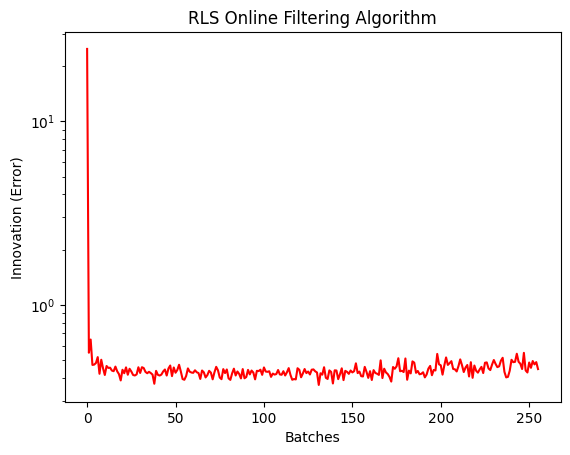

In [80]:
plt.plot(world_model.state_predictor.prediction_errors, c='red')
plt.title("RLS Online Filtering Algorithm")
plt.xlabel("Batches")
plt.ylabel("Innovation (Error)")
plt.yscale("log")
plt.savefig("/burg/home/ssa2206/sbsim_dual_control/smart_control/notebooks/RLS.png")

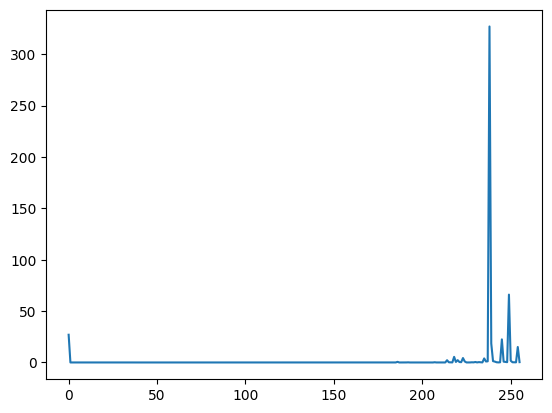

In [69]:
plt.plot(world_model2.state_predictor.prediction_errors)

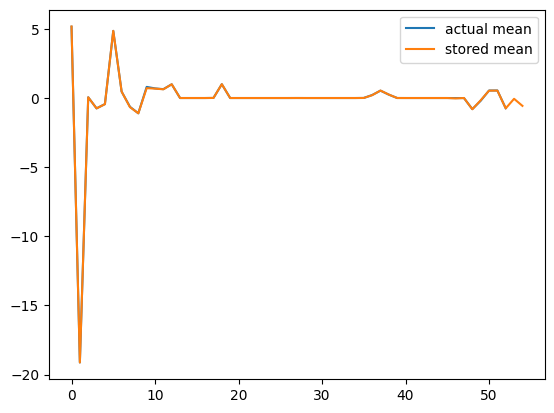

In [50]:
plt.plot(np.array(all_states).mean(axis=0).mean(axis=0), label='actual mean')
plt.plot(WM.state_predictor.mean, label='stored mean')
plt.legend()
plt.show()

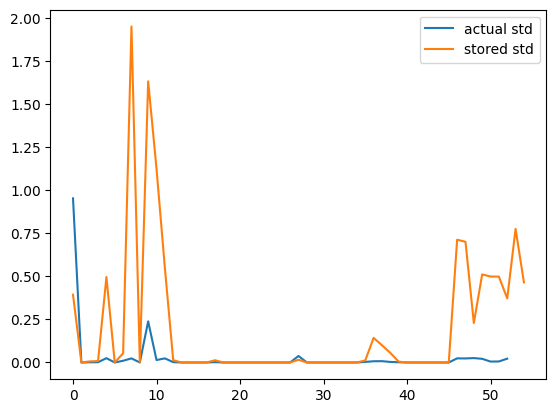

In [51]:
plt.plot(np.array(all_states).std(axis=0).std(axis=0), label='actual std')
plt.plot(WM.state_predictor.std, label='stored std')
plt.legend()
plt.show()

In [680]:
i = 0

for (experience_batch, sample_info) in dataset:
    print(i)
    states, actions, rewards = experience_batch.observation, experience_batch.action, experience_batch.reward
    at, atp1 = actions[:,0,:], actions[:, 1, :]
    st, stp1 = states[:,0,:], states[:, 1, :]
    RLS.update(st, at, stp1, debug=True)
    i += 1
RLS.prediction_errors


0
1
2
3
4


ListWrapper([21168.875, 89.35879, 47607.812, 97.35906, 1100.6337])

In [52]:
mag = lambda s : tf.sqrt(tf.reduce_sum(tf.square(s)))
def safe_normalize_state(state, curr_s, curr_a, STATE_BOUND=1000):
    """Normalize state if it exceeds bounds"""
    state_magnitude = mag(state)
    if state_magnitude > STATE_BOUND:
        print(f"State magnitude {state_magnitude} exceeded bound, normalizing...")
        print(mag(curr_s), mag(world_model.state_predictor(curr_s, curr_a)))
        #print(world_model.state_predictor.theta)
        return state * (STATE_BOUND / state_magnitude)
    return state

In [61]:
from tf_agents.trajectories import transition
def generate_rollouts(world_model, initial_state, initial_reward, initial_discount, policy, rollout_length):
    """Generate model-based rollouts with uncertainty estimation."""
    # Convert initial state to tensor and add batch dimension
    current_state = tf.expand_dims(tf.convert_to_tensor(initial_state, dtype=tf.float32), 0)
    current_reward = initial_reward
    current_discount = initial_discount
    generated_experience = []

    time_step = transition(np.array([current_state[0]], dtype=np.float32), reward=current_reward, discount=current_discount)
    action_step = policy.action(time_step)
    current_action = action_step.action

    next_state, reward, (hidden_state, cell_state) = world_model(current_state, current_action)
    state_mag = [mag(next_state)]
    for i in range(rollout_length):
        if(np.isnan(reward).any()):
            print(f"\nNaN detected at step {i}")
            print("Previous step values:")
            print(f"- Current state stats: min={tf.reduce_min(current_state)}, max={tf.reduce_max(current_state)}")
            print(f"- Current action stats: min={tf.reduce_min(current_action)}, max={tf.reduce_max(current_action)}")
            print(f"- Hidden state stats: min={tf.reduce_min(hidden_state)}, max={tf.reduce_max(hidden_state)}")
            print(f"- Cell state stats: min={tf.reduce_min(cell_state)}, max={tf.reduce_max(cell_state)}")
            
            # Check for extreme values that might have led to NaN
            print("\nExtreme value check:")
            print(f"- States > 1e3: {tf.reduce_sum(tf.cast(tf.abs(current_state) > 1e3, tf.int32))}")
            print(f"- Hidden states > 1e3: {tf.reduce_sum(tf.cast(tf.abs(hidden_state) > 1e3, tf.int32))}")
            print(f"- Cell states > 1e3: {tf.reduce_sum(tf.cast(tf.abs(cell_state) > 1e3, tf.int32))}")
            
            # Check which part of the network produced the NaN
            print("\nNetwork output inspection:")
            print(f"- Next state contains NaN: {tf.reduce_any(tf.math.is_nan(next_state))}")
            print(f"- Hidden state contains NaN: {tf.reduce_any(tf.math.is_nan(hidden_state))}")
            print(f"- Cell state contains NaN: {tf.reduce_any(tf.math.is_nan(cell_state))}")
            
            break
        else:
            time_step = transition(np.array([next_state[0]], dtype=np.float32), reward=reward, discount=current_discount)
            next_action = policy.action(time_step).action # Get action from policy

            generated_experience.append(
                dict(state=current_state.numpy(), action=current_action, reward=reward,
                next_state= next_state.numpy(), discount=current_discount.reshape(1,1))
            )

            # Update current state
            current_state, current_reward = next_state, reward
            next_state, reward, (hidden_state, cell_state) = world_model(current_state, current_action)
            #next_state = safe_normalize_state(next_state, current_state, current_action)
            state_mag.append(mag(next_state))
    return generated_experience, state_mag

In [62]:
WM.state_predictor.prediction_errors

ListWrapper([26.661097, 0.5150572, 0.514363, 0.56278795, 0.4611763, 0.48877263, 0.49592805, 0.46790233, 0.50147796, 0.49216777, 0.48189065, 0.44610703, 0.43056402, 0.43454224, 0.4138118, 0.44237864, 0.45634514, 0.45431942, 0.43705648, 0.4506846, 0.43188375, 0.39577815, 0.43904683, 0.4836048, 0.45838886, 0.44572377, 0.38226375, 0.46279696, 0.42186368, 0.46076813, 0.45624474, 0.4181336, 0.433785, 0.43342412, 0.4415, 0.42816803, 0.4356604, 0.4387361, 0.44853485, 0.41722864, 0.4548478, 0.44460803, 0.4312221, 0.4188344, 0.4627897, 0.4425989, 0.43749323, 0.43807617, 0.43168652, 0.43158382, 0.45101878, 0.4154603, 0.41982132, 0.433124, 0.4134866, 0.43816924, 0.42346108, 0.3884701, 0.45022482, 0.42906067, 0.43925214, 0.41797826, 0.42648855, 0.43041095, 0.429643, 0.44411764, 0.43287122, 0.41202402, 0.41101667, 0.40713438, 0.42586398, 0.45452204, 0.41296524, 0.44251734, 0.43245935, 0.44023347, 0.43548858, 0.40519434, 0.4548283, 0.43533158, 0.40171152, 0.4165847, 0.43623143, 0.42460003, 0.42957866

In [63]:
timestep = eval_env.reset()
initial_state, initial_reward, initial_discount = timestep.observation, timestep.reward, timestep.discount

In [64]:
rollout_length = int(4032/16)
rollout_length

252

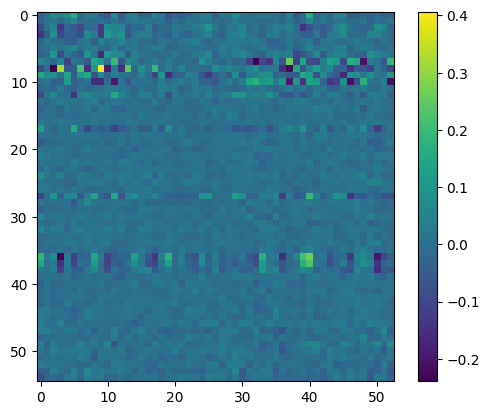

In [65]:
plt.imshow(WM.state_predictor.theta.numpy())
plt.colorbar()
plt.show()

In [66]:
singular_values = np.linalg.svd(WM.state_predictor.theta, compute_uv=False)
singular_values

array([9.90001023e-01, 9.90000665e-01, 9.90000427e-01, 7.51499951e-01,
       6.16093874e-01, 5.18069446e-01, 3.80283505e-01, 2.99484581e-01,
       2.64792562e-01, 2.55795836e-01, 2.39363432e-01, 2.22989306e-01,
       2.05524221e-01, 1.98287621e-01, 1.84072495e-01, 1.74528345e-01,
       1.64307401e-01, 1.61002293e-01, 1.55066401e-01, 1.38851076e-01,
       1.32526278e-01, 1.22645974e-01, 1.15174264e-01, 1.09827794e-01,
       1.05646044e-01, 9.57660377e-02, 9.48584229e-02, 9.00403112e-02,
       8.05175751e-02, 7.59586915e-02, 7.24350959e-02, 5.97858615e-02,
       5.43844774e-02, 5.11297919e-02, 4.73561175e-02, 4.03229930e-02,
       3.82084250e-02, 3.70188020e-02, 3.00506838e-02, 2.85922233e-02,
       2.71244086e-02, 2.60502379e-02, 2.15773284e-02, 1.58241428e-02,
       1.50188487e-02, 1.37840034e-02, 1.13960318e-02, 9.93328262e-03,
       6.30601170e-03, 4.38516773e-03, 3.18993675e-03, 1.89792051e-03,
       9.23952146e-04], dtype=float32)

In [68]:
exp, state_mags = generate_rollouts(WM, initial_state, initial_reward, initial_discount, collect_policy, 100)

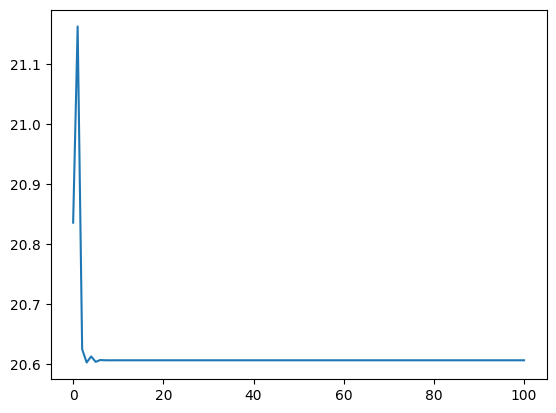

In [69]:
plt.plot(state_mags)

In [70]:
from tf_agents.trajectories import StepType
def add_to_replay_buffer(rb_observer, experience_data):
    """
    Adds experience data to the Reverb replay buffer.
    
    Args:
        rb_observer: ReverbAddTrajectoryObserver instance
        experience_data: Dict containing state, action, reward, next_state, discount
    """
    state, action, reward, next_state, discount = experience_data.values()
 
    state = state.reshape(-1) # Remove any extra dimensions
    action = tf.squeeze(action)
    next_state = tf.squeeze(next_state)
    reward = tf.squeeze(reward)
    discount = tf.squeeze(discount)
    # print(f"State shape: {state.shape}")
    # print(f"Action shape: {action.shape}")
    # print(f"Next state shape: {next_state.shape}")
    # print(f"Reward shape: {reward.shape}")
    
    # Create a Trajectory object with the required fields
    traj = trajectory.Trajectory(
        step_type=tf.constant(StepType.MID, dtype=tf.int32),
        observation=tf.constant(state, dtype=tf.float32), # Current observation/state
        action=tf.constant(action, dtype=tf.float32),
        policy_info=(),
        next_step_type=tf.constant(StepType.MID, dtype=tf.int32),
        reward=tf.constant(reward, dtype=tf.float32),
        discount=tf.constant(discount, dtype=tf.float32)
    )
    
    # Add trajectory to replay buffer
    rb_observer(traj)



In [72]:
add_to_replay_buffer(rb_observer, exp[23])

Finally we're ready to execute the RL traiing loop with SAC!

You can sepcify the total number of trainng iterations, and the number of gradient steps per iteration. With fewer steps, the model will train more slowly, but more steps may make the agent less stable.

In [719]:
# Suppress warnings
import warnings
import logging

# Suppress all warnings
warnings.filterwarnings('ignore')

logging.getLogger('tensorflow').setLevel(logging.FATAL)

# Disable TensorFlow logging
tf.get_logger().setLevel('ERROR')

In [88]:
collect_env._num_timesteps_in_episode = 10
eval_env._num_timesteps_in_episode = 10



timestep = eval_env.reset()
initial_state, initial_reward, initial_discount = timestep.observation, timestep.reward, timestep.discount

In [77]:
collect_steps_per_treining_iteration = collect_env._num_timesteps_in_episode
collect_steps_per_treining_iteration

10

576

In [90]:
# @title Execute the training loop

num_training_iterations = 1
num_gradient_updates_per_training_iteration = 10
world_model_training_steps = 64
rollout_length = int(4032/16)

# Collect the performance results with the untrained model.
#eval_actor.run_and_log()

logging_info('Training.')

# @title Modified Training Loop with World Model
# Initialize world model
state_dim = collect_env.observation_spec().shape[0]
action_dim = collect_env.action_spec().shape[0]
world_model = LinearWorldModel(state_dim, action_dim)


# log_dir = root_dir + '/train'
# with tf.summary.create_file_writer(log_dir).as_default() as writer:   


for iter in range(num_training_iterations):
    print('Training iteration: ', iter)

    collect_actor.run() # Collect real experiences

    train_world_model(world_model, reverb_replay, batch_size, training_steps=world_model_training_steps)
    initial_state, initial_reward, initial_discount = ts.observation, ts.reward, ts.discount

    synthetic_rollouts = generate_rollouts(world_model, initial_state, 
                                            initial_reward, initial_discount, collect_policy, rollout_length)
    rollout_length *= 2
    for exp in synthetic_rollouts:
        add_to_replay_buffer(rb_observer, exp)

    # Train agent with both real and synthetic data
    loss_info = agent_learner.run(iterations=num_gradient_updates_per_training_iteration)

    logging_info(
        'Actor Loss: %6.2f, Critic Loss: %6.2f, Alpha Loss: %6.2f '
        % (
            loss_info.extra.actor_loss.numpy(),
            loss_info.extra.critic_loss.numpy(),
            loss_info.extra.alpha_loss.numpy(),
        )
    )

    # Evaluate
    eval_actor.run_and_log()

rb_observer.close()
reverb_server.stop()

Training.
Training iteration:  0


ValueError: Exception encountered when calling layer 'sequential' (type Sequential).

Input 0 of layer "dense" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (53,)

Call arguments received by layer 'sequential' (type Sequential):
  • inputs=tf.Tensor(shape=(53,), dtype=float32)
  • network_state=()
  • kwargs={'step_type': 'array(0, dtype=int32)', 'training': 'False'}

## My version

### Vaibhav OG Code

In [47]:
"""
if run_model_exp:
    # @title Execute the training loop

    num_training_iterations = 10
    num_gradient_updates_per_training_iteration = 100
    

    # Collect the performance results with teh untrained model.
    eval_actor.run_and_log()

    logging_info('Training.')

    world_model = TransformerWorldModel(
        state_dim=collect_env.observation_spec().shape[0],
        action_dim=collect_env.action_spec().shape[0],
        hidden_dim=256,
        num_heads=8,
        num_transformer_blocks=3
    )

    model_buffer = ModelAssistedReplayBuffer(
        real_buffer=reverb_replay,
        world_model=world_model,
        rollout_length=5,
        rollout_ratio=0.5,
        uncertainty_threshold=0.5
    )


    # log_dir = root_dir + '/train'
    # with tf.summary.create_file_writer(log_dir).as_default() as writer:   

    for iter in range(num_training_iterations):
        print('Training iteration: ', iter)

        collect_actor.run()

        world_model_loss = train_world_model(
            world_model=world_model,
            replay_buffer=reverb_replay,
            batch_size=256,
            training_steps=1000
        )
        logging_info(f'World Model Loss: {world_model_loss:.4f}')

        real_batch = next(iter(reverb_replay.as_dataset(
            num_parallel_calls=3,
            sample_batch_size=batch_size,
            num_steps=2
        )))

        initial_states = real_batch.observation[:, 0]
        initial_actions = real_batch.action[:, 0]

        for i in range(len(initial_states)):
            generated_experience = model_buffer.generate_rollouts(
                initial_states[i],
                initial_actions[i],
                agent_collect_policy
            )

            for exp in generated_experience:
                rb_observer(trajectory.from_episode(
                    observation=exp['state'],
                    action=exp['action'],
                    policy_info=(),
                    reward=exp['reward'],
                    discount=1.0
                ))

        loss_info = agent_learner.run(
            iterations=num_gradient_updates_per_training_iteration
        )

        logging_info(
            'Actor Loss: %6.2f, Critic Loss: %6.2f, Alpha Loss: %6.2f'
            % (
                loss_info.extra.actor_loss.numpy(),
                loss_info.extra.critic_loss.numpy(),
                loss_info.extra.alpha_loss.numpy(),
            )
        )

        eval_env.reset()
        eval_actor.run_and_log()

    rb_observer.close()
    reverb_server.stop()
"""

5

5